In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

#from altaipony.flarelc import FlareLightCurve
from altaipony.fakeflares import aflare

import os
import copy

import numpy as np
import pandas as pd

#from funcs.custom_detrending import custom_detrending, iteratively_remove_sines
from funcs.funcs import read_custom_aperture_lc
from funcs.multiperiod import remove_sinusoidal, fetch_lightcurve
from funcs.flarefit import aflare2


#import astropy.units as u

from scipy import optimize
from scipy.misc import derivative

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest

In [13]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,Dec,J,R,Gaia_G,vsini_kms,e_vsini_kms,Prot_d,sini,Ref,identifier
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,40.185721,13.078,NaN,17.8356,11.2,2.2,0.37015,>.59,Gizis+13,WISEP J190648.47+401106.8
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,20.843041,15.900,NaN,19.5667,30.0,12.0,0.19300,NaN,Paudel+19,MASS J08371832+2050349
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,-62.983139,11.530,NaN,14.9796,14.4,2.6,0.35125,NaN,Kraus+14,2MASS J01180670-6258591
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,-58.933056,10.309,15.08,14.4115,NaN,NaN,0.11300,NaN,this work,SCR J0838-5855
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,-73.936397,10.630,NaN,14.7381,NaN,NaN,0.19000,NaN,this work,WISEA J105515.71-735611.3
5,300741820,8,slc,2,tess,TIC,generic,TESS,NaN,1522.00,...,-66.808885,11.959,NaN,15.3277,NaN,NaN,0.13200,NaN,Zhan+19,UCAC4 116-015389


In [14]:
target = lcs.loc[5]
target


ID                    300741820
QCS                           8
typ                         slc
cadence_min                   2
mission                    tess
prefix                      TIC
origin                  generic
h_mission                  TESS
SpT                         NaN
view_start                 1522
view_stop                  1523
view_min                    350
view_max                    600
BJDoff                  2457000
tstart                  1522.38
ampl_min                    NaN
ampl_max                    NaN
RA                      115.187
Dec                    -66.8089
J                        11.959
R                           NaN
Gaia_G                  15.3277
vsini_kms                   NaN
e_vsini_kms                 NaN
Prot_d                    0.132
sini                        NaN
Ref                     Zhan+19
identifier     UCAC4 116-015389
Name: 5, dtype: object

### Load the light curve and find the median flux and standard deviation to get a sense for the noise

11% (1987/17755) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
11% (1987/17755) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
11% (1987/17755) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
11% (1987/17755) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
11% (1987/17755) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
11% (1987/17755) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 300741820 modulation period:  3.167960564278575 h
Relative amplitude of modulation: 7.2e-03


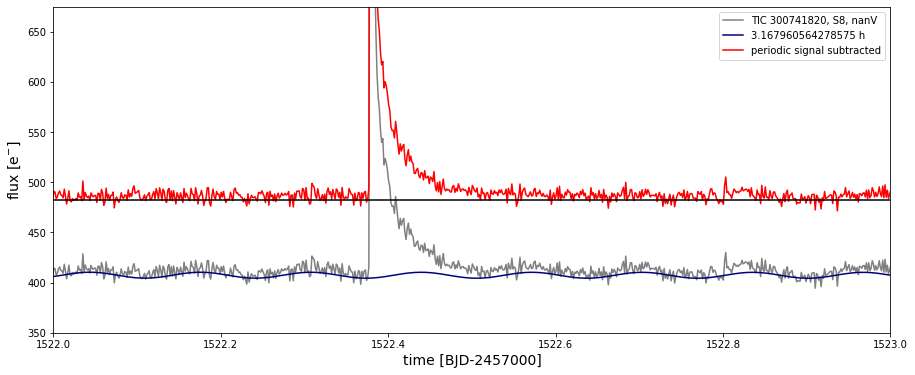

In [16]:
flck = fetch_lightcurve(target)

t, sflux, model, period = remove_sinusoidal(target, plot=True, save=True)

### Select  the part of the LC that you want to fit to. REPLACE THIS WITH DE-MODULATED FLUX

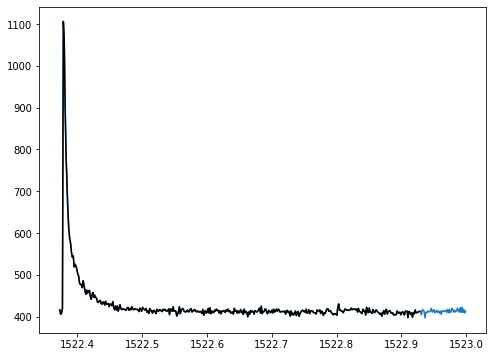

In [22]:
flc = copy.deepcopy(flck)
flc.flux[:] = sflux
median = np.nanmedian(flc.flux)
e_median = np.nanstd(flc.flux)/10.

### Select those parts of the LC that you want to use for fitting

i0, i1 = np.argmin((flc.time-target.tstart)**2)-2, np.argmin((flc.time-target.view_stop)**2)-0 #150,600 otherwise, 2,0

flc.flux_err[:] = np.nanstd(flc.flux)
flc = flc[i0:i1]
plt.figure(figsize=(8,6))
plt.plot(flc.time, flc.flux)
#a=[(0,151),(210,235),(280,310),(500,1000)]#44984200
#a= [(4,9),(15,18),(23,200)]#212035340
a= [(0,400)]#212035340
#a = [(0,100),(400,500),(910,3200)]#100004076
#a = [(0,120),(235,800)] #237880881
#a=[(0,130),(140,150),(190,210),(330,360),(480,520),(630,660)] #277539431
for i, j in a:
    plt.plot(flc.time[i:j],flc.flux[i:j],c="k")
#plt.ylim(target.view_min,target.view_max),

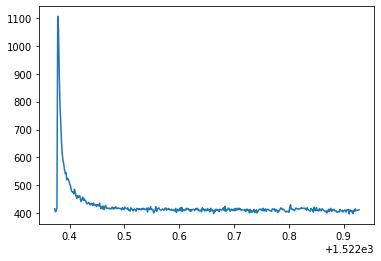

In [23]:
time = []
flux = []
flux_err = []
for i,j in a:
    time.append(flc.time[i:j])
    flux.append(flc.flux[i:j])
    flux_err.append(flc.flux_err[i:j])
time = np.array([x for sl in time for x in sl])
flux = np.array([x for sl in flux for x in sl])
flux_err = np.array([x for sl in flux_err for x in sl])
plt.plot(time, flux)


### Show the initial guess

(1522.0, 1523.0)

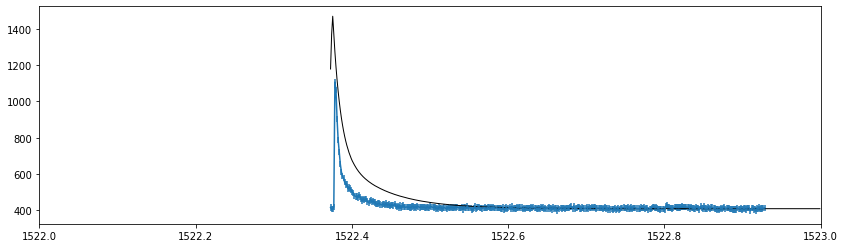

In [24]:

# Estimate the FWHM of the flare
lower = np.where(flux < np.nanmax(flux)/2)[0] #get all indices below half maximum
maximum = np.argmax(flux) #find index of maximum
before = lower[np.where(lower < maximum)] # select indices before the maximum
after = lower[np.where(lower > maximum)] # select indices after the maximum
ts, tf = (before[np.argmin((maximum-before)**2)],
          after[np.argmin((maximum-after)**2)]) # get start and end indices into times that span one FWHM
fwhm = time[tf] - time[ts]

# Guess the parameters from crude estimates
t0i, duri, ampli = target.tstart, fwhm, np.nanmax(flux)
guess = aflare2(flc.time, t0i, duri, ampli, median) 

# Plot to see if it's reasonable
plt.figure(figsize=(14,4))
plt.errorbar(x=time, y=flux,yerr=flux_err);
plt.plot(flc.time, guess, c="k",linewidth=1);
plt.xlim(target.view_start, target.view_stop)

In [25]:
def log_likelihood(theta, time, flux, flux_err, median):
    """Log likelihood function assuming 
    Gaussian uncertainties in the data points.
    SHOULDNT THIS BE POISSON?
    """
    
    t0, dur, ampl = theta
    model = aflare2(time, t0, dur, ampl, median)
    val = -0.5 * np.sum((flux - model) ** 2 / flux_err**2 + np.log(flux_err**2))
    return val


def log_prior(theta, x):
    """Uniform prior for start time,
    amplitude, and duration.
    
    - Start time shoud lie approximately 
      within the observation time.
    - Duration always positive.
    - Amplitude always positive.
    
    Parameters:
    ------------
    theta : tuple
        start time, duration, amplitude
    x : array
        time array to constrain start time
    """
    t0, dur, ampl= theta
    if x[0]-50 < t0 < x[-1] and 0.0 < dur and 0 < ampl:
        return 0.0
    return -np.inf

def log_probability(theta, time, flux, flux_err, median):
    """Posterior probability to pass to MCMC sampler.
    """
    lp = log_prior(theta, time)
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta, time, flux, flux_err, median)

In [41]:
def get_ML_fit(log_likelihood, args, inits):
    nll = lambda *args: -log_likelihood(*args)
    soln = optimize.minimize(nll, inits, args=args)
    t0_ml, dur_ml, ampl_ml = soln.x

    # Stdout
    print("Maximum likelihood estimates:")
    print(f"t0 = {t0_ml:.3f}")
    print(f"dur = {dur_ml:.3f}")
    print(f"ampl = {ampl_ml:.3f}")
    print("---------------------------------------")
    print("Message from scipy.optimize.minimize:\n")
    print(soln.message)
    return t0_ml, dur_ml, ampl_ml
    
t0_ml, dur_ml, ampl_ml = get_ML_fit(log_likelihood,
                                    args=(time, flux, flux_err, median),
                                    inits=np.array([t0i, duri, ampli]),)
print(ampl_ml)

def plot_ML_fit(target, model, results):
    flc = fetch_lightcurve(target)
    plt.figure(figsize=(8,6))
    # Plot the original flux
    plt.errorbar(flc.time, flc.flux, yerr=flc.flux_err, fmt=".k", capsize=0, alpha=.1)

    # Plot 
    plt.plot(flc.time,aflare2(flc.time, t0_ml, dur_ml, ampl_ml,median), ":k", label="ML")
    plt.legend(fontsize=14)
    plt.xlabel("")
    plt.ylabel("y");

Maximum likelihood estimates:
t0 = 1522.379
dur = 0.004
ampl = 890.770
---------------------------------------
Message from scipy.optimize.minimize:

Desired error not necessarily achieved due to precision loss.
890.770092687754


In [29]:
import emcee

pos = np.array([t0_ml, dur_ml, ampl_ml]) + 1e-4 * np.random.randn(32, 3)
#pos = initial + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, flux, flux_err, median))
sampler.run_mcmc(pos, 500, progress=True);

100%|██████████| 500/500 [00:20<00:00, 24.49it/s]


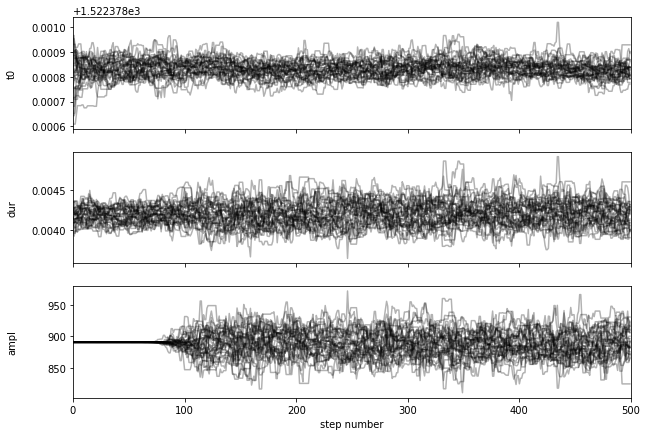

In [30]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["t0", "dur", "ampl"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


(960, 3)


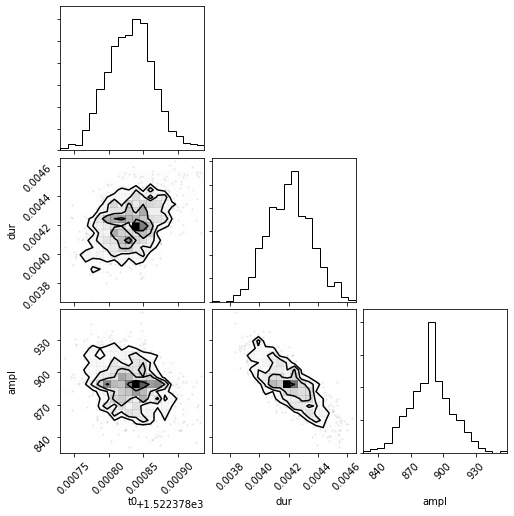

In [32]:
import corner
flat_samples = sampler.get_chain(discard=40, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels, truths=[t0i,duri,ampli]);

No handles with labels found to put in legend.


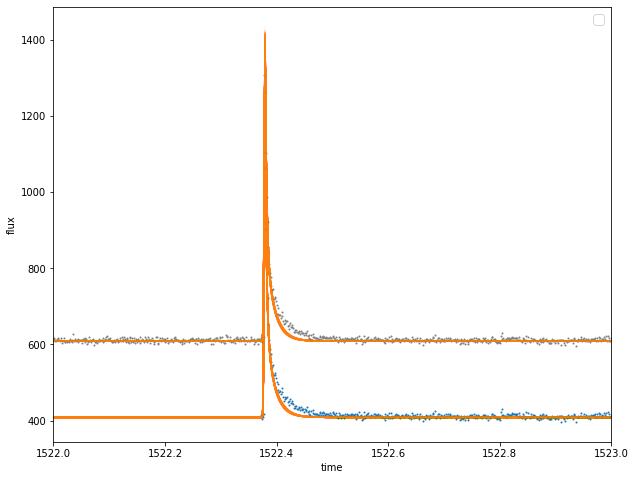

In [49]:
inds = np.random.randint(len(flat_samples), size=300)
plt.figure(figsize=(10,8))
t_ = np.linspace(target.view_start, target.view_stop,800)
plt.scatter(flc.time, flc.flux, s=1)
plt.scatter(t, sflux+200, s=1, c="grey")
#plt.errorbar(time, flux, yerr=flux_err, fmt=".k", capsize=0)

for ind in inds:
    sample = flat_samples[ind]
    plt.plot(t_, aflare2(t_, *sample[:3], median), "C1", alpha=0.05)
    plt.plot(t_, aflare2(t_, *sample[:3], median)+200, "C1", alpha=0.05)

#plt.plot(flc.time, truth, "k", label="init gues", linewidth=1)
plt.legend(fontsize=14)
#plt.xlim(10, 13)
plt.xlabel("time")
plt.ylabel("flux");
plt.xlim(target.view_start, target.view_stop);

In [50]:
samples = sampler.chain[:, 40:, :].reshape((-1, ndim))
#samples[:, 2] = np.exp(samples[:, 2])
t0_mcmc, dur_mcmc, ampl_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
t0_mcmc, dur_mcmc, ampl_mcmc

((1522.3788321887987, 3.279238967479614e-05, 3.31688152073184e-05),
 (0.004201907121963584, 0.0001498045465747411, 0.00014357906636771733),
 (890.3937819413553, 17.356715910325192, 21.070331203379965))

In [51]:
e_t0 = (t0_mcmc[1] + t0_mcmc[2])/2.
e_dur = (dur_mcmc[1] + dur_mcmc[2])/2.
e_ampl = (ampl_mcmc[1] + ampl_mcmc[2])/2.

In [52]:

def ED(t, t0, dur, ampl, median):
    x = t * 60.0 * 60.0 * 24.0
    return np.sum(np.diff(x) * aflare(t, t0, dur, ampl)[:-1]) / (dur * 6 * median)

In [53]:

def t0_ED(x):
    return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
def dur_ED(x):
    return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
def ampl_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
def median_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

(615.2241793230386,
 891.0862555403181,
 3428.199851224823,
 360099.83779929165,
 14081.666917649545)

In [54]:
check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
assert E_median == pytest.approx(E_median,rel=1e-4)
e_median, median

(1.7442607879638672, 408.76248)

In [55]:
EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
EDval,e_ED

(27809.076329920295, 615.2241793230386)

In [261]:
with open(f"{CWD}/data/summary/results.csv", "a") as k:
    stri = (f"{target.prefix} {target.ID},{EDval:.0f},{e_ED:.0f},"\
            f"{t0_mcmc[0]:.5f},{e_t0:.5f},"\
            f"{dur_mcmc[0]*6:.5f},{e_dur*6:.5f},"\
            f"{ampl_mcmc[0]/median:.5f},{e_ampl/median:.5f}\n"\
            f"{period.value:.2f}")
   # stri = "ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot_h\n"
    k.write(stri)